In [1]:
from pathlib import Path 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy as sp; from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy import sparse
import random
import pathlib
from matplotlib.patches import Polygon
import pickle


In [7]:
results_file = Path('.').resolve() / '001_som3_mpc_boptest.pkl'
if results_file.exists():
    with open(results_file, 'rb') as f:
        results = pickle.load(f)

# print(results['_x', 't_indoor'])

variables = results['mpc'].result_queries
print('MPC Variables')
print(f"{'Type':>11}{'Name':>20}")
print(f"{'----':>11}{'----':>20}")
for v in variables['ind']:
    if len(v) > 2:
        continue
    print(f"{v[0]:>10}:{v[1]:>20}")
    
# display(results['mpc'].data_fields)
display(results['mpc']['_x', 't_indoor'][0])
out = results['mpc'].prediction(('_u','heating_power'), t_ind=3)
display(out.shape)
# display(out[0])

# calculate the time axis as fraction of hours starting at t=0
sim_data = results['mpc']
# use np array to allow for the mask
time_data = np.array([x * (5/60) for x in range(sim_data['_x', 't_indoor'].size)])

# parse out the dr_start and dr_end. Use the elec cost is greater than 10. 
elec_cost = sim_data['_tvp', 'ElecCost']
isevent = (elec_cost > 10).flatten()
# display(list(isevent))
display(time_data[isevent])

# manually set the fields below based on the data
dr_start_1 = 15
dr_end_1   = 17




MPC Variables
       Type                Name
       ----                ----
      _tvp:             TDryBul
        _u:       heating_power
      _tvp:     TSetpoint_Lower
      _tvp:     TSetpoint_Upper
        _x:            t_indoor
      _tvp:            ElecCost
      _aux:                cost


array([293.])

(1, 96, 1)

array([15.        , 15.08333333, 15.16666667, 15.25      , 15.33333333,
       15.41666667, 15.5       , 15.58333333, 15.66666667, 15.75      ,
       15.83333333, 15.91666667, 16.        , 16.08333333, 16.16666667,
       16.25      , 16.33333333, 16.41666667, 16.5       , 16.58333333,
       16.66666667, 16.75      , 16.83333333, 16.91666667, 39.        ,
       39.08333333, 39.16666667, 39.25      , 39.33333333, 39.41666667,
       39.5       , 39.58333333, 39.66666667, 39.75      , 39.83333333,
       39.91666667, 40.        , 40.08333333, 40.16666667, 40.25      ,
       40.33333333, 40.41666667, 40.5       , 40.58333333, 40.66666667,
       40.75      , 40.83333333, 40.91666667])

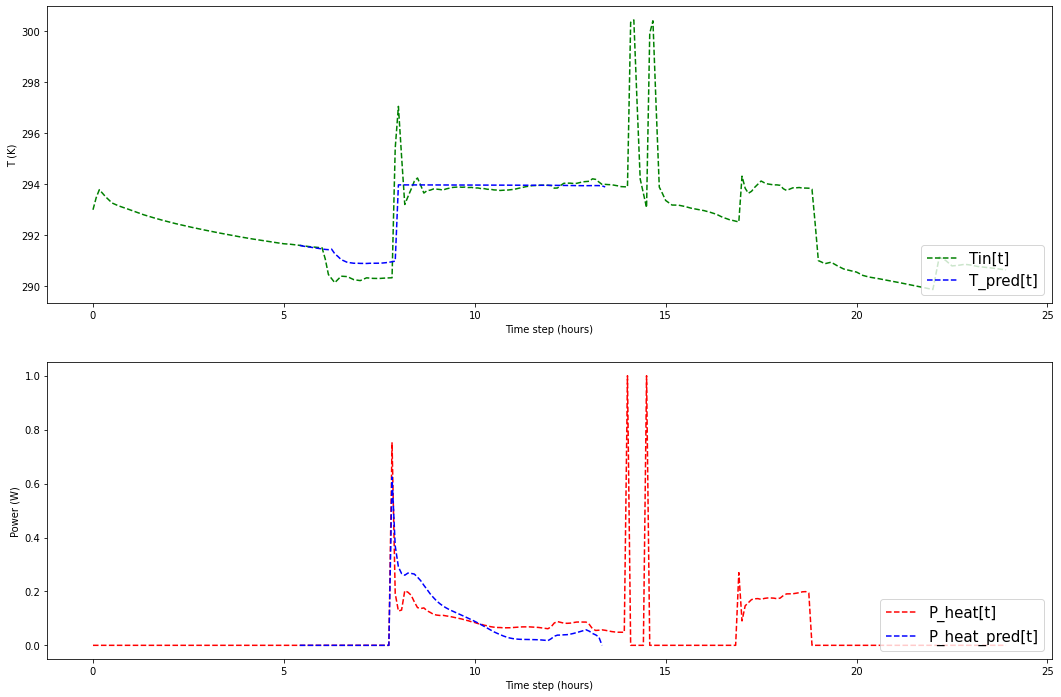

In [8]:
# Test plotting some variables 

# max_t: max range of values for the actual observations
# mpc_t_ind: index from which to start the MPC predictions
max_t = 288
mpc_t_ind=65
mpc_horizon = 97

k=plt.figure(figsize=(18,12),facecolor='white')
y1 = k.add_subplot(2,1,1)
y1.plot(time_data[:max_t], sim_data['_x', 't_indoor'][:max_t], 'g--', label="Tin[t]")
mpc_data = sim_data.prediction(('_x', 't_indoor'), t_ind=mpc_t_ind)[0]  # there is only one element on this state variable.
y1.plot(time_data[mpc_t_ind:mpc_t_ind+mpc_horizon], mpc_data, 'b--', label="T_pred[t]")
y1.set_xlabel('Time step (hours)')
y1.set_ylabel('T (K)')
y1.legend(loc=4, prop={"size":15})

y2 = k.add_subplot(2,1,2)
y2.plot(time_data[:max_t], sim_data['_u', 'heating_power'][:max_t], 'r--', label="P_heat[t]")
mpc_data = sim_data.prediction(('_u', 'heating_power'), t_ind=mpc_t_ind)[0]
y2.plot(time_data[mpc_t_ind:mpc_t_ind+mpc_horizon-1], mpc_data, 'b--', label="P_heat_pred[t]")
y2.set_xlabel('Time step (hours)')
y2.set_ylabel('Power (W)')
y2.legend(loc=4, prop={"size":15})


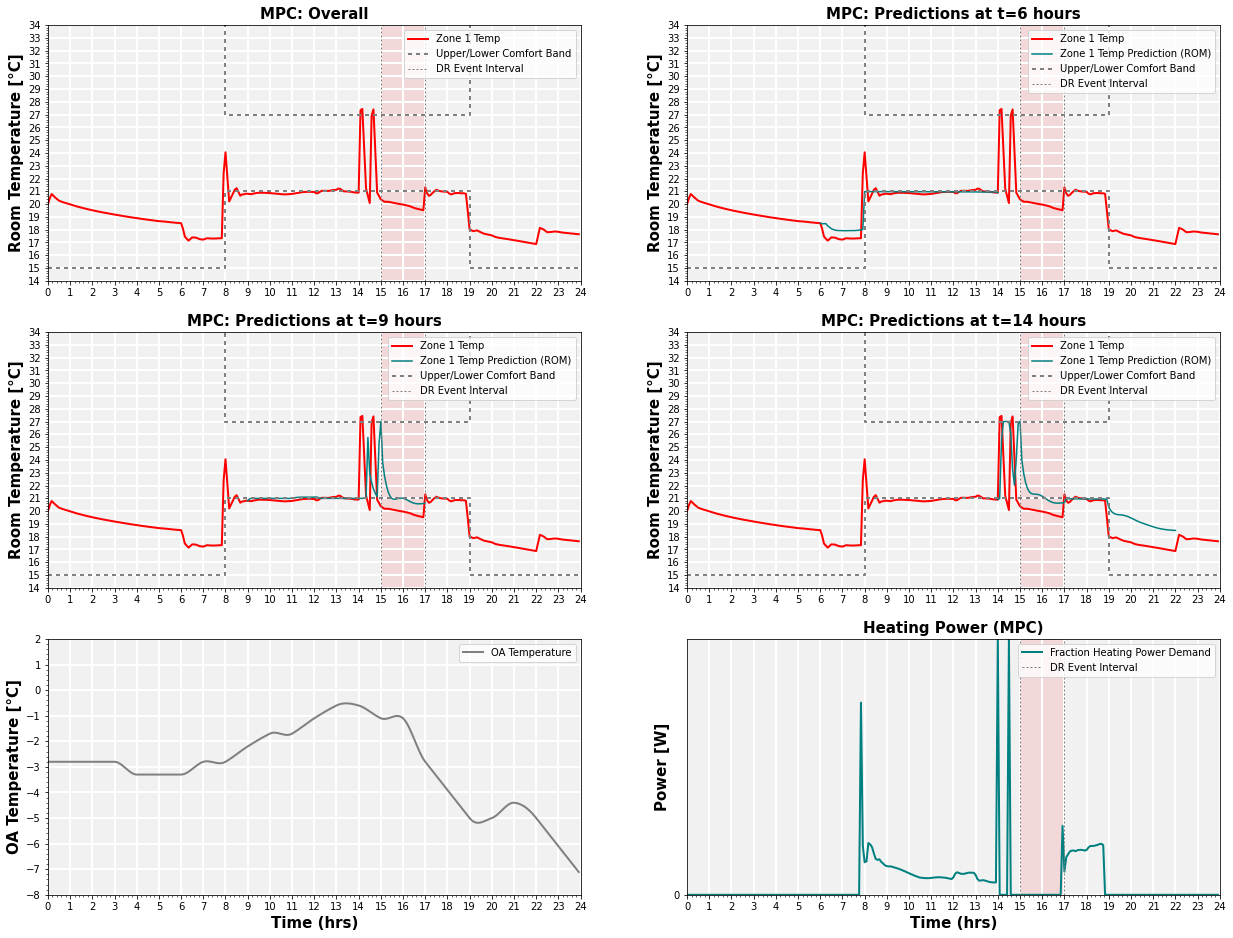

In [12]:
# configuration variables
max_t = 288

mpc_horizon = 97  # for _x and _tvp, _u is -1 (for some reason)

rect_1 = Polygon(((dr_start_1,8), (dr_start_1,40), (dr_end_1, 40),(dr_end_1,8)),
                 fc=(1,0,0,0.1), ec=(0,0,0,1), lw=0,linestyle='--')
rect_2 = Polygon(((dr_start_1,8), (dr_start_1,40), (dr_end_1, 40),(dr_end_1,8)),
                 fc=(1,0,0,0.1), ec=(0,0,0,1), lw=0,linestyle='--')
rect_3 = Polygon(((dr_start_1,8), (dr_start_1,40), (dr_end_1, 40),(dr_end_1,8)),
                 fc=(1,0,0,0.1), ec=(0,0,0,1), lw=0,linestyle='--')
rect_4 = Polygon(((dr_start_1,8), (dr_start_1,40), (dr_end_1, 40),(dr_end_1,8)),
                 fc=(1,0,0,0.1), ec=(0,0,0,1), lw=0,linestyle='--')
# rect_5 is not needed since it is temperature plot
rect_6 = Polygon(((dr_start_1,0), (dr_start_1,16000), (dr_end_1, 16000),(dr_end_1,0)),
                    fc=(1,0,0,0.1), ec=(0,0,0,1), lw=0,linestyle='--')


f=plt.figure(figsize=(21,16))
#f.suptitle('DQN Performance in Episode: '+str(episode),size=24, y =.95)
#filt_data["Hours"]= filt_data["Hours"]%24

up_limit=34
low_limit=14

x1 = f.add_subplot(3,2,1)

x1.plot(time_data[:max_t], sim_data['_x', 't_indoor'][:max_t]-273, label= "Zone 1 Temp",color="red", linewidth = 2)
x1.step(time_data[:max_t], sim_data['_tvp', 'TSetpoint_Lower'][:max_t]-273, where="post", label= "Upper/Lower Comfort Band", color="grey", linestyle='--', dashes=(2, 2), linewidth = 2)
x1.step(time_data[:max_t], sim_data['_tvp', 'TSetpoint_Upper'][:max_t]-273, where="post", color="grey", linestyle='--', dashes=(2, 2), linewidth = 2)
# x1.fill_between(rom_data_r_st['Hours'],rom_data_r_st['min_Temp'],rom_data_r_st['max_Temp'], facecolor='lightblue',edgecolor='k', linewidth=0.5,zorder=6,alpha=0.4)

x1.axvline(x = dr_start_1, color = 'grey',linestyle='--',linewidth = 1,dashes=(2, 2))
x1.axvline(x = dr_end_1, color = 'grey',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
x1.add_artist(rect_1)
x1.set_xlim([0, 24])
x1.set_ylim([low_limit, up_limit])
x1.yaxis.set_major_locator(ticker.MultipleLocator(1))
x1.xaxis.set_major_locator(ticker.MultipleLocator(1))
x1.minorticks_on()
x1.grid(which='major',linewidth=2,color='white')
x1.set_ylabel('Room Temperature [°C]',fontsize=15,fontweight='bold')
x1.legend(loc=4,prop={"size":15})
x1.set_facecolor("gainsboro")
x1.patch.set_alpha(0.4)
x1.set_title('MPC: Overall',fontweight='bold',fontsize=15)
x1.legend(loc=1)

t_mpc_hour = 6
t_mpc = t_mpc_hour * 12  # 5 minute intervals
x2 = f.add_subplot(3,2,2)
x2.plot(time_data[:max_t], sim_data['_x', 't_indoor'][:max_t]-273, label= "Zone 1 Temp",color="red", linewidth = 2)
x2.plot(time_data[t_mpc:t_mpc+mpc_horizon], sim_data.prediction(('_x', 't_indoor'), t_ind=t_mpc)[0]-273, label= "Zone 1 Temp Prediction (ROM)",color="teal", linewidth = 1.5)
x2.step(time_data[:max_t], sim_data['_tvp', 'TSetpoint_Lower'][:max_t]-273, where="post", label= "Upper/Lower Comfort Band", color="grey", linestyle='--', dashes=(2, 2), linewidth = 2)
x2.step(time_data[:max_t], sim_data['_tvp', 'TSetpoint_Upper'][:max_t]-273, where="post", color="grey", linestyle='--', dashes=(2, 2), linewidth = 2)
x2.axvline(x = dr_start_1, color = 'grey',linestyle='--',linewidth = 1,dashes=(2, 2))
x2.axvline(x = dr_end_1, color = 'grey',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
x2.add_artist(rect_2)
x2.set_xlim([0, 24])
x2.set_ylim([low_limit, up_limit])
x2.yaxis.set_major_locator(ticker.MultipleLocator(1))
x2.xaxis.set_major_locator(ticker.MultipleLocator(1))
x2.minorticks_on()
x2.grid(which='major',linewidth=2,color='white')
x2.set_ylabel('Room Temperature [°C]',fontsize=15,fontweight='bold')
x2.legend(loc=4,prop={"size":15})
x2.set_facecolor("gainsboro")
x2.patch.set_alpha(0.4)
x2.set_title(f'MPC: Predictions at t={t_mpc_hour} hours',fontweight='bold',fontsize=15)
x2.legend(loc=1)

t_mpc_hour = 9
t_mpc = t_mpc_hour * 12  # 5 minute intervals
x3 = f.add_subplot(3,2,3)
x3.plot(time_data[:max_t], sim_data['_x', 't_indoor'][:max_t]-273, label= "Zone 1 Temp",color="red", linewidth = 2)
x3.plot(time_data[t_mpc:t_mpc+mpc_horizon], sim_data.prediction(('_x', 't_indoor'), t_ind=t_mpc)[0]-273, label= "Zone 1 Temp Prediction (ROM)",color="teal", linewidth = 1.5)
x3.step(time_data[:max_t], sim_data['_tvp', 'TSetpoint_Lower'][:max_t]-273, where="post", label= "Upper/Lower Comfort Band", color="grey", linestyle='--', dashes=(2, 2), linewidth = 2)
x3.step(time_data[:max_t], sim_data['_tvp', 'TSetpoint_Upper'][:max_t]-273, where="post", color="grey", linestyle='--', dashes=(2, 2), linewidth = 2)
x3.axvline(x = dr_start_1, color = 'grey',linestyle='--',linewidth = 1,dashes=(2, 2))
x3.axvline(x = dr_end_1, color = 'grey',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
x3.add_artist(rect_3)
x3.set_xlim([0, 24])
x3.set_ylim([low_limit, up_limit])
x3.yaxis.set_major_locator(ticker.MultipleLocator(1))
x3.xaxis.set_major_locator(ticker.MultipleLocator(1))
x3.minorticks_on()
x3.grid(which='major',linewidth=2,color='white')
x3.set_ylabel('Room Temperature [°C]',fontsize=15,fontweight='bold')
x3.legend(loc=4,prop={"size":15})
x3.set_facecolor("gainsboro")
x3.patch.set_alpha(0.4)
x3.set_title(f'MPC: Predictions at t={t_mpc_hour} hours',fontweight='bold',fontsize=15)
x3.legend(loc=1)

t_mpc_hour = 14
t_mpc = t_mpc_hour * 12  # 5 minute intervals
x4 = f.add_subplot(3,2,4)
x4.plot(time_data[:max_t], sim_data['_x', 't_indoor'][:max_t]-273, label= "Zone 1 Temp",color="red", linewidth = 2)
x4.plot(time_data[t_mpc:t_mpc+mpc_horizon], sim_data.prediction(('_x', 't_indoor'), t_ind=t_mpc)[0]-273, label= "Zone 1 Temp Prediction (ROM)",color="teal", linewidth = 1.5)
x4.step(time_data[:max_t], sim_data['_tvp', 'TSetpoint_Lower'][:max_t]-273, where="post", label= "Upper/Lower Comfort Band", color="grey", linestyle='--', dashes=(2, 2), linewidth = 2)
x4.step(time_data[:max_t], sim_data['_tvp', 'TSetpoint_Upper'][:max_t]-273, where="post", color="grey", linestyle='--', dashes=(2, 2), linewidth = 2)
x4.axvline(x = dr_start_1, color = 'grey',linestyle='--',linewidth = 1,dashes=(2, 2))
x4.axvline(x = dr_end_1, color = 'grey',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
x4.add_artist(rect_4)
x4.set_xlim([0, 24])
x4.set_ylim([low_limit, up_limit])
x4.yaxis.set_major_locator(ticker.MultipleLocator(1))
x4.xaxis.set_major_locator(ticker.MultipleLocator(1))
x4.minorticks_on()
x4.grid(which='major',linewidth=2,color='white')
x4.set_ylabel('Room Temperature [°C]',fontsize=15,fontweight='bold')
x4.legend(loc=4,prop={"size":15})
x4.set_facecolor("gainsboro")
x4.patch.set_alpha(0.4)
x4.set_title(f'MPC: Predictions at t={t_mpc_hour} hours',fontweight='bold',fontsize=15)
x4.legend(loc=1)

x5 = f.add_subplot(3,2,5)
x5.plot(time_data[:max_t], sim_data['_tvp', 'TDryBul'][:max_t], label= "OA Temperature",color="grey", linewidth = 2)
x5.set_xlim([0, 24])
x5.set_ylim([-8, 2])
x5.yaxis.set_major_locator(ticker.MultipleLocator(1))
x5.xaxis.set_major_locator(ticker.MultipleLocator(1))
x5.minorticks_on()
x5.grid(which='major', linewidth=2,color='white')
x5.set_ylabel('OA Temperature [°C]',fontsize=15,fontweight='bold')
x5.set_facecolor("gainsboro")
x5.set_xlabel('Time (hrs)',fontsize=15,fontweight='bold')
x5.patch.set_alpha(0.4)
x5.legend(loc=1)

x6 = f.add_subplot(3,2,6)
x6.plot(time_data[:max_t], sim_data['_u', 'heating_power'][:max_t], label= "Fraction Heating Power Demand", color="teal", linewidth = 2)
x6.set_xlim([0, 24])
x6.yaxis.set_major_locator(ticker.MultipleLocator(1000))
x6.xaxis.set_major_locator(ticker.MultipleLocator(1))
x6.set_xlabel('Time in Hours',fontsize=15)
x6.minorticks_on()
x6.set_ylabel('Power [W]',fontsize=15,fontweight='bold')
x6.grid(which='major', linewidth=2,color='white')
x6.set_xlabel('Time (hrs)',fontsize=15,fontweight='bold')
x6.add_artist(rect_6)
x6.axvline(x = dr_start_1, color = 'grey',linestyle='--',linewidth = 1,dashes=(2, 2))
x6.axvline(x = dr_end_1, color = 'grey',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
x6.set_title("Heating Power (MPC)",fontweight='bold',fontsize=15)
x6.set_facecolor("gainsboro")
x6.patch.set_alpha(0.4)
x6.set_ylim([0, 1])
x6.legend(loc=1)


z='MPC_Performance_1.jpg'

plt.savefig(z,dpi=400)

In [46]:
# Code below here is Sourav's code for reference!


episode_r=50
rom_data_r_end = pd.read_csv("data_rom.csv")
#full_data_r = full_data_r[full_data_r['episodes']==episode_r]
rom_data_r_end.drop(rom_data_r_end.columns[0],axis=1,inplace=True)
rom_data_r_end.reset_index(inplace=True)
rom_data_r_end['time']=rom_data_r_end['time'].astype('float')
rom_data_r_end['Hours']=rom_data_r_end['time']/3600
#rom_data_r_200['states']=rom_data_r_200['states'].map(lambda x: np.array((x.strip('[').strip(']').split())))
rom_data_r_end['Room_Air_Temp_Z0']=rom_data_r_end['Temp_z0']
rom_data_r_end['Room_Air_Temp_Z0']=rom_data_r_end['Room_Air_Temp_Z0']-273.15
rom_data_r_end['Room_Air_Temp_Z1']=rom_data_r_end['Temp_z1']
rom_data_r_end['Room_Air_Temp_Z1']=rom_data_r_end['Room_Air_Temp_Z1']-273.15
rom_data_r_end['Room_Air_Temp_Z2']=rom_data_r_end['Temp_z2']
rom_data_r_end['Room_Air_Temp_Z2']=rom_data_r_end['Room_Air_Temp_Z2']-273.15
rom_data_r_end['Room_Air_Temp_Z3']=rom_data_r_end['Temp_z3']
rom_data_r_end['Room_Air_Temp_Z3']=rom_data_r_end['Room_Air_Temp_Z3']-273.15
rom_data_r_end['Room_Air_Temp_Z4']=rom_data_r_end['Temp_z4']
rom_data_r_end['Room_Air_Temp_Z4']=rom_data_r_end['Room_Air_Temp_Z4']-273.15

k = 273.15
rom_data_r_end['Lower_Setpoint']= 294.15-k
rom_data_r_end.loc[rom_data_r_end['Hours'].astype(int)< 8, 'Lower_Setpoint'] = 291.15-k
rom_data_r_end.loc[rom_data_r_end['Hours'].astype(int)>= 17, 'Lower_Setpoint'] = 291.15-k

rom_data_r_end['Upper_Setpoint']= 297.15-k
rom_data_r_end.loc[rom_data_r_end['Hours'].astype(int)< 8, 'Upper_Setpoint'] = 300.15-k
rom_data_r_end.loc[rom_data_r_end['Hours'].astype(int)>= 17, 'Upper_Setpoint'] = 300.15-k


rom_data_r_end['min_Temp'] = rom_data_r_end[['Room_Air_Temp_Z0','Room_Air_Temp_Z1','Room_Air_Temp_Z2','Room_Air_Temp_Z3','Room_Air_Temp_Z4']].min(axis=1)
rom_data_r_end['mean_Temp'] =rom_data_r_end[['Room_Air_Temp_Z0','Room_Air_Temp_Z1','Room_Air_Temp_Z2','Room_Air_Temp_Z3','Room_Air_Temp_Z4']].mean(axis=1)
rom_data_r_end['max_Temp'] = rom_data_r_end[['Room_Air_Temp_Z0','Room_Air_Temp_Z1','Room_Air_Temp_Z2','Room_Air_Temp_Z3','Room_Air_Temp_Z4']].max(axis=1)



rom_data_r_st = rom_data_r_end[rom_data_r_end['episodes']==1]
rom_data_r_end = rom_data_r_end[rom_data_r_end['episodes']==episode_r]

rom_data_r_end.tail()

,index,time,states,rewards,episodes,Energy,Th_Disc,Temp_z0,Temp_z1,Temp_z2,...,Room_Air_Temp_Z0,Room_Air_Temp_Z1,Room_Air_Temp_Z2,Room_Air_Temp_Z3,Room_Air_Temp_Z4,Lower_Setpoint,Upper_Setpoint,min_Temp,mean_Temp,max_Temp
283,283,84900.0,[0.76263356 0.9861111 0. 0. ],0.0,50,0.0,0.0,299.068855,298.797844,299.000308,...,25.918855,25.647845,25.850308,26.080397,25.576452,18.0,27.0,25.576452,25.814771,26.080397
284,284,85200.0,[0.737263 0.9895833 0. 0. ],0.0,50,0.0,0.0,298.717011,298.411633,298.495490,...,25.567011,25.261634,25.345490,25.678912,25.064221,18.0,27.0,25.064221,25.383453,25.678912
285,285,85500.0,[0.7285343 0.9930556 0. 0. ],0.0,50,0.0,0.0,298.956818,297.169119,298.582693,...,25.806818,24.019119,25.432693,25.763717,25.152944,18.0,27.0,24.019119,25.235058,25.806818
286,286,85800.0,[0.7306497 0.99652773 0. 0. ],0.0,50,0.0,0.0,298.807886,297.579049,298.715154,...,25.657886,24.429049,25.565154,25.641328,25.061777,18.0,27.0,24.429049,25.271039,25.657886
287,287,86100.0,[0.7077752 0. 0. 0. ],0.0,50,0.0,0.0,299.076928,297.987454,298.047323,...,25.926928,24.837454,24.897323,24.448483,24.300752,18.0,27.0,24.300752,24.882188,25.926928


In [77]:
episode=67
full_data = pd.read_csv("data_spawn.csv")
#full_data = full_data[full_data['episodes']==episode]

full_data.drop(full_data.columns[0],axis=1,inplace=True)
full_data.reset_index(inplace=True)

full_data['time']=full_data['time'].astype('float')
full_data['rewards']=full_data["rewards"].astype('float')
full_data['action_1']=full_data['action_1'].astype('float')
full_data['episodes']=full_data['episodes'].astype('float')
full_data['Total_Pow_Dem_1']=full_data['Total_Pow_Dem_1'].astype('float')
full_data['Room_Air_Temp_Z0']=full_data['senTRoom_y'] -273.15
full_data['Room_Air_Temp_Z1']=full_data['senTRoom1_y'] -273.15
full_data['Room_Air_Temp_Z2']=full_data['senTRoom2_y'] -273.15
full_data['Room_Air_Temp_Z3']=full_data['senTRoom3_y'] -273.15
full_data['Room_Air_Temp_Z4']=full_data['senTRoom4_y'] -273.15
full_data['min_Temp'] = full_data[['Room_Air_Temp_Z0','Room_Air_Temp_Z1','Room_Air_Temp_Z2','Room_Air_Temp_Z3','Room_Air_Temp_Z4']].min(axis=1)
full_data['mean_Temp'] = full_data[['Room_Air_Temp_Z0','Room_Air_Temp_Z1','Room_Air_Temp_Z2','Room_Air_Temp_Z3','Room_Air_Temp_Z4']].mean(axis=1)
full_data['max_Temp'] = full_data[['Room_Air_Temp_Z0','Room_Air_Temp_Z1','Room_Air_Temp_Z2','Room_Air_Temp_Z3','Room_Air_Temp_Z4']].max(axis=1)
full_data['action_1']=full_data['action_1']-273.15
full_data['senTemOA_y']=full_data['senTemOA_y'] -273.15
full_data["Total_Pow_HVAC"] =full_data["Total_Pow_Dem_0"]+full_data["Total_Pow_Dem_1"]+full_data["Total_Pow_Dem_2"]+full_data["Total_Pow_Dem_3"]+full_data["Total_Pow_Dem_4"]

#df['OA_temp_4']=df['states'].map(lambda x: float(x[2]));df['OA_temp_4']=df['OA_temp_4']-273.15
#df['winDir']=df['states'].map(lambda x: float(x[3]))
#df['Global_Hor']=df['states'].map(lambda x:float(x[4]))
full_data['Hours']=((full_data['time'])/3600)%24

full_data.tail()

,index,time,states,rewards,episodes,action_1,dr_start,dr_end,reward_energy,reward_tdisc,...,Room_Air_Temp_Z0,Room_Air_Temp_Z1,Room_Air_Temp_Z2,Room_Air_Temp_Z3,Room_Air_Temp_Z4,min_Temp,mean_Temp,max_Temp,Total_Pow_HVAC,Hours
4027,4027,84900.0,[0.79417896 0.9861111 0. 0. ],-0.004094,67.0,33.0,14.053575,15.18771,0.003475,0.0,...,25.893157,26.190556,26.713464,26.149468,26.808566,25.893157,26.351042,26.808566,41.700859,23.583333
4028,4028,85200.0,[0.79402196 0.9895833 0. 0. ],-0.004099,67.0,33.0,14.053575,15.18771,0.003480,0.0,...,25.893544,26.188507,26.707882,26.148145,26.803790,25.893544,26.348374,26.803790,41.750819,23.666667
4029,4029,85500.0,[0.79391325 0.9930556 0. 0. ],-0.004103,67.0,33.0,14.053575,15.18771,0.003483,0.0,...,25.893767,26.186987,26.704141,26.147137,26.800595,25.893767,26.346526,26.800595,41.800939,23.750000
4030,4030,85800.0,[0.7937706 0.9965278 0. 0. ],-0.004108,67.0,33.0,14.053575,15.18771,0.003488,0.0,...,25.894172,26.185090,26.699083,26.145894,26.796265,25.894172,26.344101,26.796265,41.851222,23.833333
4031,4031,86100.0,[0.79367024 0. 0. 0. ],-0.004113,67.0,33.0,14.053575,15.18771,0.003492,0.0,...,25.894375,26.183648,26.695677,26.144917,26.793353,25.894375,26.342394,26.793353,41.901669,23.916667


In [78]:
k = 273.15
full_data['Lower_Setpoint']= 294.15-k
full_data.loc[full_data['Hours'].astype(int)< 8, 'Lower_Setpoint'] = 291.15-k
full_data.loc[full_data['Hours'].astype(int)>= 17, 'Lower_Setpoint'] = 291.15-k

full_data['Upper_Setpoint']= 297.15-k
full_data.loc[full_data['Hours'].astype(int)< 8, 'Upper_Setpoint'] = 300.15-k
full_data.loc[full_data['Hours'].astype(int)>= 17, 'Upper_Setpoint'] = 300.15-k

In [105]:
last_ep = 66
filt_data_st = full_data[full_data['episodes']==51]
filt_data_end = full_data[full_data['episodes']==last_ep]


In [106]:
dr_start_1 = filt_data_st['dr_start'].reset_index(drop=True)[0]
dr_start_2 = filt_data_end['dr_start'].reset_index(drop=True)[0]
dr_end_1 = filt_data_st['dr_end'].reset_index(drop=True)[0]
dr_end_2 = filt_data_end['dr_end'].reset_index(drop=True)[0]

dr_start_r1 =rom_data_r_st.iloc[0]['dr_start']
dr_end_r1   =rom_data_r_st.iloc[0]['dr_end']
dr_start_r2 = rom_data_r_end.iloc[0]['dr_start']
dr_end_r2   =  rom_data_r_end.iloc[0]['dr_end']

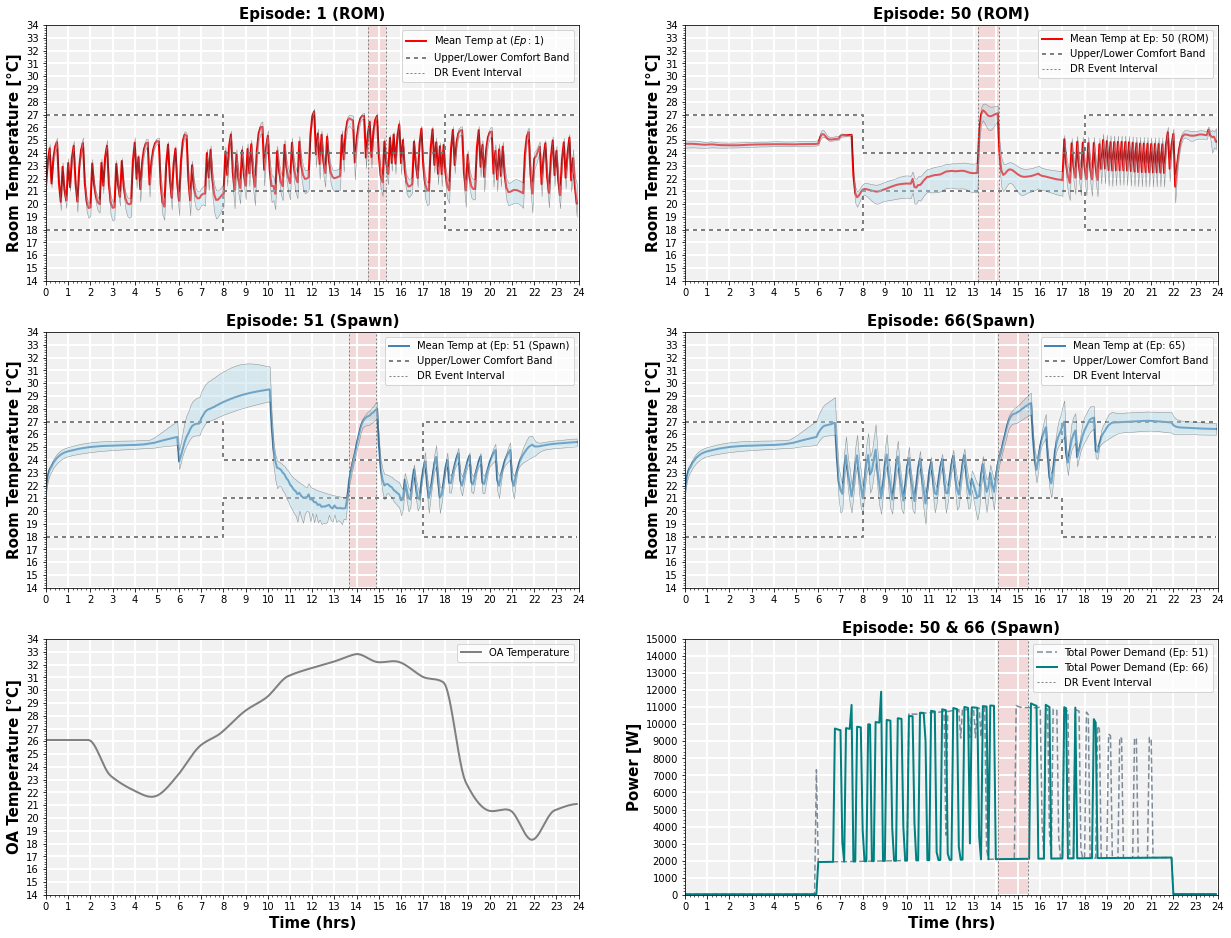

In [107]:
filt_data = full_data[full_data['episodes']==episode]

rect_1 = Polygon(((dr_start_1,8), (dr_start_1,40), (dr_end_1, 40),(dr_end_1,8)),
                    fc=(1,0,0,0.1), ec=(0,0,0,1), lw=0,linestyle='--')
rect_2 = Polygon(((dr_start_2,8), (dr_start_2,40), (dr_end_2, 40),(dr_end_2,8)),
                    fc=(1,0,0,0.1), ec=(0,0,0,1), lw=0,linestyle='--')

rect_3 = Polygon(((dr_start_2,0), (dr_start_2,16000), (dr_end_2, 16000),(dr_end_2,0)),
                    fc=(1,0,0,0.1), ec=(0,0,0,1), lw=0,linestyle='--')

rect_r1 = Polygon(((dr_start_r1,0), (dr_start_r1,16000), (dr_end_r1, 16000),(dr_end_r1,0)),
                    fc=(1,0,0,0.1), ec=(0,0,0,1), lw=0,linestyle='--')

rect_r2 = Polygon(((dr_start_r2,0), (dr_start_r2,16000), (dr_end_r2, 16000),(dr_end_r2,0)),
                    fc=(1,0,0,0.1), ec=(0,0,0,1), lw=0,linestyle='--')



f=plt.figure(figsize=(21,16))
#f.suptitle('DQN Performance in Episode: '+str(episode),size=24, y =.95)
#filt_data["Hours"]= filt_data["Hours"]%24

up_limit=34
low_limit=14

x1 = f.add_subplot(3,2,1)
#x1.plot(filt_data['Hours'],filt_data["Room_Air_Temp_Z0"], label= "Temp_Core",color="r", linewidth = 1.5)
x1.plot(rom_data_r_st['Hours'],rom_data_r_st["mean_Temp"], label= "Mean Temp at ($Ep:1$)",color="red", linewidth = 2)
x1.step(rom_data_r_st['Hours'],rom_data_r_st['Lower_Setpoint'],where="post",label= "Upper/Lower Comfort Band",color="grey",linestyle='--',dashes=(2, 2),linewidth = 2)
x1.step(rom_data_r_st['Hours'],rom_data_r_st['Upper_Setpoint'],where="post",color="grey",linestyle='--',dashes=(2, 2),linewidth = 2)
x1.fill_between(rom_data_r_st['Hours'],rom_data_r_st['min_Temp'],rom_data_r_st['max_Temp'], facecolor='lightblue',edgecolor='k', linewidth=0.5,zorder=6,alpha=0.4)

#x1.axvline(x = dr_start, color = 'k',linestyle='--', label = 'DR Event',linewidth = 1,dashes=(2, 2))
#x1.axvline(x = dr_end, color = 'k',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
#x1.add_artist(rect_1)
#x1.step(full_data['Hours'],full_data['action'],where='post',label= "Set_Point_Action",color="k", linewidth = 1)
#x1.axhline(y=308.15-273.15,color ='darkslategrey', linestyle='--',dashes=(2, 3),linewidth = 1.5)
#x1.axhline(y=283.15-273.15,color ='darkslategrey', linestyle='--',dashes=(2, 3),linewidth = 1.5)
x1.axvline(x = dr_start_r1, color = 'grey',linestyle='--',linewidth = 1,dashes=(2, 2))
x1.axvline(x = dr_end_r1, color = 'grey',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
x1.add_artist(rect_r1)
x1.set_xlim([0, 24])
x1.set_ylim([low_limit, up_limit])
x1.yaxis.set_major_locator(ticker.MultipleLocator(1))
x1.xaxis.set_major_locator(ticker.MultipleLocator(1))
x1.minorticks_on()
x1.grid(which='major',linewidth=2,color='white')
x1.set_ylabel('Room Temperature [°C]',fontsize=15,fontweight='bold')
x1.legend(loc=4,prop={"size":15})
x1.set_facecolor("gainsboro")
x1.patch.set_alpha(0.4)
x1.set_title('Episode: 1 (ROM)',fontweight='bold',fontsize=15)
x1.legend(loc=1)


x2 = f.add_subplot(3,2,2)
# x2.plot(filt_data['Hours'],filt_data["Total_Pow_Dem_0"], label= "Total Power Demand Core ",color="red", linewidth = 1.5,dashes=(4, 2))
# x2.plot(filt_data['Hours'],filt_data["Total_Pow_Dem_1"], label= "Total Power Demand Zone 1",color="blue", linewidth = 1.5,dashes=(4, 2))
x2.plot(rom_data_r_end['Hours'],rom_data_r_end["mean_Temp"], label= "Mean Temp at Ep: "+str(episode_r)+" (ROM)",color="r", linewidth = 2)
x2.step(rom_data_r_end['Hours'],rom_data_r_end['Lower_Setpoint'],where="post",label= "Upper/Lower Comfort Band",color="grey",linestyle='--',dashes=(2, 2),linewidth = 2)
x2.step(rom_data_r_end['Hours'],rom_data_r_end['Upper_Setpoint'],where="post",color="grey",linestyle='--',dashes=(2, 2),linewidth = 2)
# x3.plot(filt_data['Hours'],filt_data["Room_Air_Temp"], label= "Room Air Temperature",color="r", linewidth = 1.5)
# x3.step(filt_data['Hours'],filt_data['action'],where='post',label= "Set_Point_Action",color="k", linewidth = 1)
# x3.axhline(y=308.15-273.15,color ='darkslategrey', linestyle='--',dashes=(2, 3),linewidth = 1.5)
# x3.axhline(y=283.15-273.15,color ='darkslategrey', linestyle='--',dashes=(2, 3),linewidth = 1.5)
x2.add_artist(rect_r2)
x2.set_xlim([0, 24])
x2.set_ylim([low_limit, up_limit])
x2.set_ylabel('Room Temperature [°C]',fontsize=15,fontweight='bold')
# x3.set_ylim([low_limit, up_limit])
x2.yaxis.set_major_locator(ticker.MultipleLocator(1))
x2.xaxis.set_major_locator(ticker.MultipleLocator(1))
x2.fill_between(rom_data_r_end['Hours'],rom_data_r_end['min_Temp'],rom_data_r_end['max_Temp'], facecolor='lightblue',edgecolor='k', linewidth=0.5,zorder=6,alpha=0.4)
x2.minorticks_on()
x2.grid(which='major', linewidth=2,color='white')
x2.axvline(x = dr_start_r2, color = 'grey',linestyle='--',linewidth = 1,dashes=(2, 2))
x2.axvline(x = dr_end_r2, color = 'grey',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
# x3.axhline(y=21,color ='blue', linestyle='--',dashes=(2, 3))
# x3.axhline(y=24,color ='blue', linestyle='--',dashes=(2, 3))
x2.set_facecolor("gainsboro")
x2.patch.set_alpha(0.4)
x2.set_title("Episode: "+str(episode_r)+" (ROM)",fontweight='bold',fontsize=15)
x2.legend(loc=1)



x3 = f.add_subplot(3,2,3)

#x2.plot(filt_data['Hours'],filt_data["Total_Pow_Dem_0"], label= "Total Power Demand Core ",color="red", linewidth = 1.5,dashes=(4, 2))
x3.plot(filt_data_st['Hours'],filt_data_st["mean_Temp"], label= "Mean Temp at (Ep: "+str(episode_r+1)+" (Spawn)",color="steelblue", linewidth = 2)
x3.step(filt_data_st['Hours'],filt_data_st['Lower_Setpoint'],where="post",label= "Upper/Lower Comfort Band",color="grey",linestyle='--',dashes=(2, 2),linewidth = 2)
x3.step(filt_data_st['Hours'],filt_data_st['Upper_Setpoint'],where="post",color="grey",linestyle='--',dashes=(2, 2),linewidth = 2)
x3.fill_between(filt_data_st['Hours'], filt_data_st['min_Temp'], filt_data_st['max_Temp'], facecolor='lightblue',edgecolor='k', linewidth=0.5,zorder=6,alpha=0.4)
# x3.plot(filt_data['Hours'],filt_data["Room_Air_Temp_Z2"], label= "Temp_Z2",color="r", linewidth = 1.5)
# x3.plot(filt_data['Hours'],filt_data["Room_Air_Temp_Z3"], label= "Temp_Z3",color="blue", linewidth = 1.5)
# x3.plot(filt_data['Hours'],filt_data["Room_Air_Temp_Z4"], label= "Temp_Z4",color="green", linewidth = 1.5)
# x3.plot(filt_data['Hours'],filt_data['OA_temp_0'], label= "OA_temp",color="orange", linewidth = 1.5)
# x3.step(filt_data['Hours'],filt_data['Lower_Setpoint'],where="post",label= "Upper/Lower Comfort Band",color="k",linestyle='--',dashes=(2, 2),linewidth = 2)
# x3.step(filt_data['Hours'],filt_data['action_1'],where="post",label= "Cooling_Coil SP Action",color="blue",linestyle='--',dashes=(2,1),linewidth = 1.5,alpha=0.6)
# x3.step(filt_data['Hours'],filt_data['Upper_Setpoint'],where="post",color="k",linestyle='--',dashes=(2, 2),linewidth = 2)
#x1.step(full_data['Hours'],full_data['action'],where='post',label= "Set_Point_Action",color="k", linewidth = 1)
#x1.axhline(y=308.15-273.15,color ='darkslategrey', linestyle='--',dashes=(2, 3),linewidth = 1.5)
#x1.axhline(y=283.15-273.15,color ='darkslategrey', linestyle='--',dashes=(2, 3),linewidth = 1.5)
x3.set_xlim([0, 24])
x3.set_ylim([low_limit, up_limit])
x3.yaxis.set_major_locator(ticker.MultipleLocator(1))
x3.xaxis.set_major_locator(ticker.MultipleLocator(1))
x3.axvline(x = dr_start_1, color = 'grey',linestyle='--',linewidth = 1,dashes=(2, 2))
x3.axvline(x = dr_end_1, color = 'grey',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
x3.minorticks_on()
x3.add_artist(rect_1)
x3.grid(which='major', linewidth=2,color='white')
x3.set_ylabel('Room Temperature [°C]',fontsize=15,fontweight='bold')
x3.set_facecolor("gainsboro")
x3.patch.set_alpha(0.4)
x3.set_title("Episode: "+str(episode_r+1)+" (Spawn)",fontweight='bold',fontsize=15)
#x3.set_title('Episode:'+ str(episode))
x3.legend(loc=1)


x4 = f.add_subplot(3,2,4)

#x1.plot(filt_data['Hours'],filt_data["OA_temp_0"], label= "Temp_OA",color="orange", linewidth = 1.5)
#x1.plot(filt_data['Hours'],filt_data['OA_temp_0'], label= "OA_temp",color="coral", linewidth = 1.5,dashes=(4, 2))
x4.plot(filt_data_end['Hours'],filt_data_end["mean_Temp"], label= "Mean Temp at (Ep: "+str(last_ep-1)+")",color="steelblue", linewidth = 2)
x4.step(filt_data_end['Hours'],filt_data_end['Lower_Setpoint'],where="post",label= "Upper/Lower Comfort Band",color="grey",linestyle='--',dashes=(2, 2),linewidth = 2)
#x1.step(filt_data['Hours'],filt_data['action_1'],where="post",label= "Cooling_Coil SP Action",color="blue",linestyle='--',dashes=(2,1),linewidth = 1.5,alpha=0.6)
x4.step(filt_data_end['Hours'],filt_data_end['Upper_Setpoint'],where="post",color="grey",linestyle='--',dashes=(2, 2),linewidth = 2)
#x1.axvline(x = dr_start, color = 'k',linestyle='--', label = 'DR Event',linewidth = 1,dashes=(2, 2))
#x1.axvline(x = dr_end, color = 'k',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
#x1.add_artist(rect_1)
#x1.step(full_data['Hours'],full_data['action'],where='post',label= "Set_Point_Action",color="k", linewidth = 1)
#x1.axhline(y=308.15-273.15,color ='darkslategrey', linestyle='--',dashes=(2, 3),linewidth = 1.5)
#x1.axhline(y=283.15-273.15,color ='darkslategrey', linestyle='--',dashes=(2, 3),linewidth = 1.5)
x4.fill_between(filt_data_end['Hours'], filt_data_end['min_Temp'], filt_data_end['max_Temp'], facecolor='lightblue',edgecolor='k', linewidth=0.5,zorder=6,alpha=0.4)
x4.set_xlim([0, 24])
x4.set_ylim([low_limit, up_limit])
x4.yaxis.set_major_locator(ticker.MultipleLocator(1))
x4.xaxis.set_major_locator(ticker.MultipleLocator(1))
x4.minorticks_on()
x4.grid(which='major',linewidth=2,color='white')
x4.set_ylabel('Room Temperature [°C]',fontsize=15,fontweight='bold')
x4.set_title('Episode:'+ str(episode))
x4.set_facecolor("gainsboro")
x4.patch.set_alpha(0.4)
x4.add_artist(rect_2)
x4.axvline(x = dr_start_2, color = 'grey',linestyle='--',linewidth = 1,dashes=(2, 2))
x4.axvline(x = dr_end_2, color = 'grey',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
x4.set_title("Episode: "+str(last_ep)+"(Spawn)",fontweight='bold',fontsize=15)
x4.legend(loc=1)


x5 = f.add_subplot(3,2,5)
x5.plot(filt_data_st['Hours'],filt_data_st['senTemOA_y'], label= "OA Temperature",color="grey", linewidth = 2)
x5.set_xlim([0, 24])
x5.set_ylim([low_limit, up_limit])
x5.yaxis.set_major_locator(ticker.MultipleLocator(1))
x5.xaxis.set_major_locator(ticker.MultipleLocator(1))
x5.minorticks_on()
x5.grid(which='major', linewidth=2,color='white')
x5.set_ylabel('OA Temperature [°C]',fontsize=15,fontweight='bold')
x5.set_facecolor("gainsboro")
x5.set_xlabel('Time (hrs)',fontsize=15,fontweight='bold')
x5.patch.set_alpha(0.4)
x5.legend(loc=1)



x6 = f.add_subplot(3,2,6)
#x1.plot(filt_data['Hours'],filt_data["Room_Air_Temp_Z0"], label= "Temp_Core",color="r", linewidth = 1.5)
x6.plot(filt_data_st['Hours'],filt_data_st["Total_Pow_HVAC"], label= "Total Power Demand (Ep: "+str(episode_r+1)+")",color="slategrey", linewidth = 1.5,dashes=(4, 2),alpha=0.9)
x6.plot(filt_data_end['Hours'],filt_data_end["Total_Pow_HVAC"], label= "Total Power Demand (Ep: "+str(last_ep)+")",color="teal", linewidth = 2)
x6.set_xlim([0, 24])
x6.yaxis.set_major_locator(ticker.MultipleLocator(1000))
x6.xaxis.set_major_locator(ticker.MultipleLocator(1))
x6.set_xlabel('Time in Hours',fontsize=15)
x6.minorticks_on()
x6.set_ylabel('Power [W]',fontsize=15,fontweight='bold')
x6.grid(which='major', linewidth=2,color='white')
x6.set_xlabel('Time (hrs)',fontsize=15,fontweight='bold')
x6.add_artist(rect_3)
x6.axvline(x = dr_start_2, color = 'grey',linestyle='--',linewidth = 1,dashes=(2, 2))
x6.axvline(x = dr_end_2, color = 'grey',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
x6.set_title("Episode: "+str(episode_r)+" & "+str(last_ep)+" (Spawn)",fontweight='bold',fontsize=15)
x6.set_facecolor("gainsboro")
x6.patch.set_alpha(0.4)
x6.set_ylim([0, 15000])
x6.legend(loc=1)

z='DQN_Performance_3a.jpg'

plt.savefig(z,dpi=400)